In [18]:
import random
import scipy.linalg as linalg
import math
import numpy as np
import matplotlib.pyplot as plt

In [109]:
n = 100
mu_const = np.random.randn(n)
A_default = np.random.randint(-10, 10, size = n ** 2).reshape((n, n))/10
A_default

array([[ 0.1,  0.7, -0.4, ..., -1. ,  0.5,  0.9],
       [ 0.5,  0.8, -0.7, ...,  0.2, -0.5,  0.1],
       [ 0.9, -0.3, -0.3, ...,  0.2,  0.1, -0.4],
       ...,
       [ 0.7,  0.7,  0.8, ...,  0.8, -0.6,  0.8],
       [-0.8,  0.4, -0.2, ..., -0.3, -0.7,  0.3],
       [ 0.4,  0.2, -0.3, ..., -0.2,  0.5,  0.2]])

In [110]:
from numpy.linalg import inv

color_list = ['b', 'brown', 'g', 'r', 'black', 'gray']
class generate_model(object):
    
    def __init__(self, n = n, sigma = 0.05, several = False, A_default = True):
        self._n = n
        self._B = None
        self._mu = None
        self._F = None
        self._A = None
        self._S = np.identity(n) * sigma ** 2
        self._sigma = sigma
        self._x0 = np.zeros((n, )) # В случае белого шума
        self._several = several
        self._A_is_default = A_default
        
    def generate_wnoise(self):
        if self._mu is not None:
            return self
        if not self._several:
            self._mu = np.random.randn(self._n) 
        else:
            self._mu = mu_const
    
    def create_operator_B(self, l = 10):
        # при создании оператора B в случае надобности создаём априорную информацию
        # Оператор B сглаживание усреднением в окне ширины l
        if self._B is not None:
            return self
        self._B = np.zeros((self._n - l + 1, self._n))
        for idx in range(self._n - l + 1):
            self._B[idx][idx: idx + l] = 1.
        self._B = (1/l) * self._B
        for idx in range(l - 1, 0, -1):
            dop = np.zeros((self._n, ))
            dop[self._n - idx: ] = (1/idx) 
            self._B = np.concatenate((self._B, dop[None, :]))
        self._F = np.dot(self._B, self._B.T)
    
    def get_x(self):
        if self._B is None or self._mu is None:
            self.create_operator_B() # l default
            self.generate_wnoise() # too default params
        return np.dot(self._B, self._mu)
    
    def create_A( self):
        if self._A is not None:
            return self
        # A should be 
        # Сделаем матрицу A некоторой случайной 
        if self._A_is_default:
            self._A = A_default
        else:
            self._A = np.zeros((self._n, self._n))
            self._A = np.random.randint(-10, 10, size = self._n * self._n).reshape((self._n, self._n))/10
        

    def get_y(self):
        if self._A is None or self._B is None or self._mu is None:
            self.create_operator_B()
            self.generate_wnoise()
            self.create_A()
        self._y = np.dot(self._A, self.get_x()) + np.random.randn(self._n) * self._sigma
        return self._y
    
    def get_single_pack_data(self):
        y = self.get_y()
        A = self._A
        S = self._S
        return (y, A, S)
    
    def get_est_x(self):
        # даст оценку с учётом априорного знания 
        A = self._A
        S = self._S
        F = self._F
        
        Q = inv(np.dot(A.T, np.dot(inv(S), A)) + inv(F))
        est_x = np.dot(Q, np.dot(np.dot(A.T, inv(S)), self._y) + np.dot(inv(F), self._x0))
        return est_x
    
    def get_std_deviation(self):
        # Даст стандартное отклонение с учётом априорного знания 
        A = self._A
        S = self._S
        F = self._F
        
        Q = inv(np.dot(A.T, np.dot(inv(S), A)) + inv(F))
        d = np.asarray([np.sqrt(Q[idx, idx]) for idx in range(Q.shape[0])])
        return d
        
    @staticmethod
    def show_graphs(**signals):
        fig, ax = plt.subplots(figsize = (14, 7))
        idx = 0
        sigma  = None
        for name, signal in signals.items():
            if name != 'sigma':
                lenght = len(signal)
                if 'plus' in name or 'minus' in name:
                    ax.plot(list(range(lenght)), signal, 
                            c = 'black',
                            label = name, linewidth = 1. if 'plus' in name or 'minus' in name else 1.5, 
                            linestyle = '-.' if 'plus' in name or 'minus' in name else '-')
                else:
                    ax.plot(list(range(lenght)), signal, 
                            c = color_list[idx] if idx < len(color_list) else color_list[idx % len(color_list)],
                            label = name, linewidth = 1. if 'plus' in name or 'minus' in name else 1.5, 
                            linestyle = '-.' if 'plus' in name or 'minus' in name else '-')
                ax.legend()
                idx += 1
            else:
                sigma = signal
            
            
        ax.grid()
        ax.set_xlabel('Отсчёты x_i')
        ax.set_ylabel('Отклонения')
        if sigma is not None:
            ax.set_title('noise of sigma = {}'.format(sigma))
        
        

In [151]:
def several_graph_shows(list_data):
    fig, ax = plt.subplots(figsize = (10, 7))
    for idx in range(len(list_data)):
        ax.plot(range(1, len(list_data[idx])+1, 1), list_data[idx], 
                    c = color_list[idx] if idx < len(color_list) else color_list[idx % len(color_list)])
        ax.grid()
        


число калибровочных данных k : 3
 число отсчётов n : 100
(100,)
(100,)
(100,)


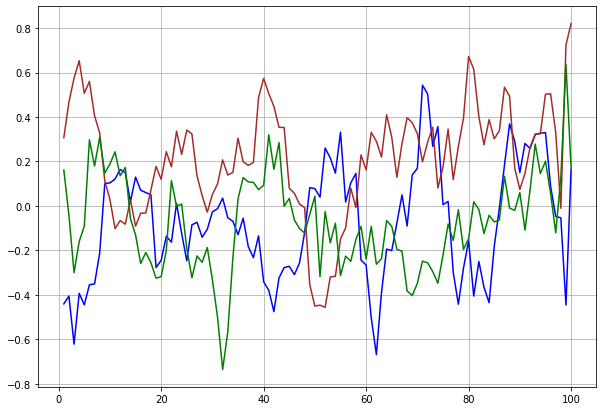

In [115]:
k = 3
def calibrovochnii(k = k, n = n):
    print("число калибровочных данных k : {}\n число отсчётов n : {}".format(k, n))
    phi_list = []
    psi_list = []
    G = np.zeros((n, n))
    H = np.zeros((n, n))
    phi = 0
    psi = 0
    for item in range(k):
        cls_curr = generate_model(several = False, A_default = True)
        phi = cls_curr.get_x()
        psi = cls_curr.get_y()
        G += np.dot(psi[:, None], phi[:, None].T)
        H += np.dot(phi[:, None], phi[:, None].T)
        phi_list.append(phi)
        psi_list.append(psi)
        #cls_curr.show_graphs(x = cls_curr.get_x())
    
    phi_list = np.asarray(phi_list)
    psi_list = np.asarray(psi_list)
    
    return phi_list, psi_list

phi_list, psi_list = calibrovochnii(k = k)
several_graph_shows(phi_list)

In [118]:
def data_to_canonicalINFO(y, A, S):
    # return (T, v) - CI for single data
    T = np.dot(A.T, np.dot(inv(S), A))
    v = np.dot(A.T, np.dot(inv(S), y))
    return (T, v)

def priordata_to_canonicalINFO(x_0, F_0):
    return (inv(F_0), np.dot(inv(F_0), x_0)) # (T_0, v_0)

def estimate_single(CI):
    # return (est_x, D(x - est_x)) for single data
    T, v = CI 
    return (np.dot(inv(T), v), inv(T))
def update_sum_CI(CI1, CI2):
    # CI : (T, v)
    return (CI1[0] + CI2[0], CI1[1] + CI2[1])
def calibr_to_CI(list_phi, list_psi):
    k = len(list_psi)
    G = np.zeros((n, n))
    H = np.zeros((n, n))
    for item in range(k):
        G += np.dot(list_psi[item][:, None], list_phi[item][:, None].T)
        H += np.dot(list_phi[item][:, None], list_phi[item][:, None].T)
    return (G, H)

phi, psi = calibrovochnii(k = 10, n = n)
calibr_to_CI(phi, psi)

число калибровочных данных k : 10
 число отсчётов n : 100


(array([[-2.00988425, -0.73907014, -1.09362443, ..., -0.19132163,
          1.79826171,  9.73539694],
        [-4.07769046, -2.77943842, -2.96569631, ...,  2.11535572,
          3.17273803,  9.23392938],
        [ 1.03175223,  0.51033778, -0.14769344, ...,  2.698567  ,
          1.53879563,  6.24281529],
        ...,
        [ 0.80549999,  0.84649201,  0.37056242, ..., 13.5861425 ,
         17.04185091, 29.92203998],
        [-1.6761266 ,  0.07437985,  0.08090828, ..., -1.73091203,
         -0.71665349,  5.17943207],
        [ 2.10221433,  0.06274974,  0.24634887, ...,  5.87820552,
          5.69776665,  6.32577072]]),
 array([[ 8.75866755e-01,  5.69498811e-01,  5.33903831e-01, ...,
          2.05813819e-01, -7.16968944e-01, -1.03078551e+00],
        [ 5.69498811e-01,  5.23777717e-01,  4.43705882e-01, ...,
          3.11355068e-01, -1.54492301e-01, -3.18153182e-01],
        [ 5.33903831e-01,  4.43705882e-01,  4.57272501e-01, ...,
          7.01229540e-04, -5.39986825e-01, -6.60560752e-

In [149]:
def estimate_ver_1(k = 100):
    cls_obj = generate_model(A_default = True) # generate 
    y, A, S = cls_obj.get_single_pack_data()
    F, x0 = cls_obj._F, cls_obj._x0

    phi_l, psi_l = calibrovochnii(k = k, n = n)
    CI_cal = calibr_to_CI(phi_l, psi_l)
    G, H = CI_cal
    A0 = np.dot(G, inv(H))
    J = np.trace(np.dot(inv(H), F)) * S
    
    #cls_obj._A = A_0
    #cls_obj._S = J + cls._S
    #cls_obj._F = cls_obj._F
    
    S_ = J + S
    Q = inv(np.dot(A0.T, np.dot(inv(S_), A0)) + inv(F))
    R = np.dot(Q, np.dot(A0.T, inv(S_)))
    r = np.dot(Q, np.dot(inv(F), x0))
    est_x = np.dot(R, y) + r
    d_est = np.asarray([np.sqrt(Q[idx, idx]) for idx in range(cls_obj._n)])
    return est_x, cls_obj.get_x(), d_est
    

число калибровочных данных k : 100
 число отсчётов n : 100


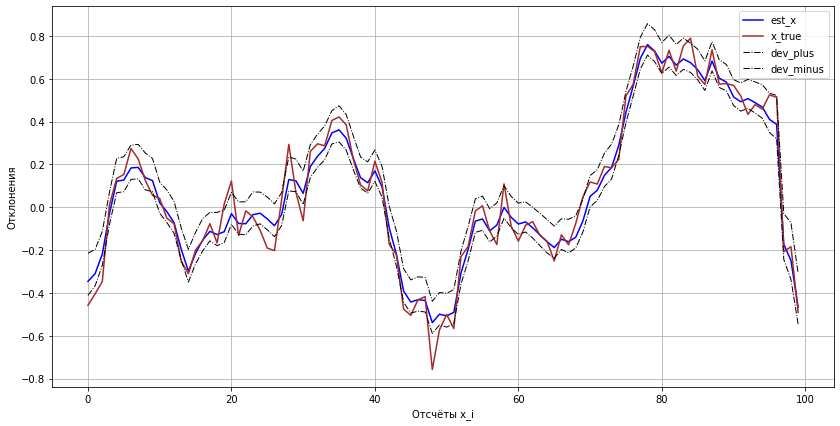

In [167]:
est_x, true_x, d_est = estimate_ver_1(k = 100)
#several_graph_shows([est_x, true_x, est_x + d_est / 2, est_x - d_est / 2])
cls = generate_model()
cls.show_graphs(est_x = est_x, x_true = true_x, dev_plus = est_x + d_est, dev_minus = est_x - d_est / 2)

In [185]:
def estimate_ver_2(k = 100, N = 10):
    sum_y = np.zeros((n, ))
    for i in range(N):
        cls_curr = generate_model(A_default = True, several = True) # Один и тот же x, A
        sum_y += cls_curr.get_y()
        if i == 0:
            S = cls_curr._S
            F, x0 = cls_curr._F, cls_curr._x0
            x_true = cls_curr.get_x()
    # we take aver_y, N, S
    S = S / N
    y = sum_y / N
    
    phi_l, psi_l = calibrovochnii(k = k, n = n)
    print('число данных N: {}'.format(N))
    CI_cal = calibr_to_CI(phi_l, psi_l)
    G, H = CI_cal
    A0 = np.dot(G, inv(H))
    J = np.trace(np.dot(inv(H), F)) * S
    
    #cls_obj._A = A_0
    #cls_obj._S = J + cls._S
    #cls_obj._F = cls_obj._F
    
    S_ = J + S
    Q = inv(np.dot(A0.T, np.dot(inv(S_), A0)) + inv(F))
    R = np.dot(Q, np.dot(A0.T, inv(S_)))
    r = np.dot(Q, np.dot(inv(F), x0))
    est_x = np.dot(R, y) + r
    d_est = np.asarray([np.sqrt(Q[idx, idx]) for idx in range(n)])
    return est_x, x_true, d_est
     

СЛУЧАЙ МАЛОГО N, K ~ 10
число калибровочных данных k : 10
 число отсчётов n : 100
число данных N: 10


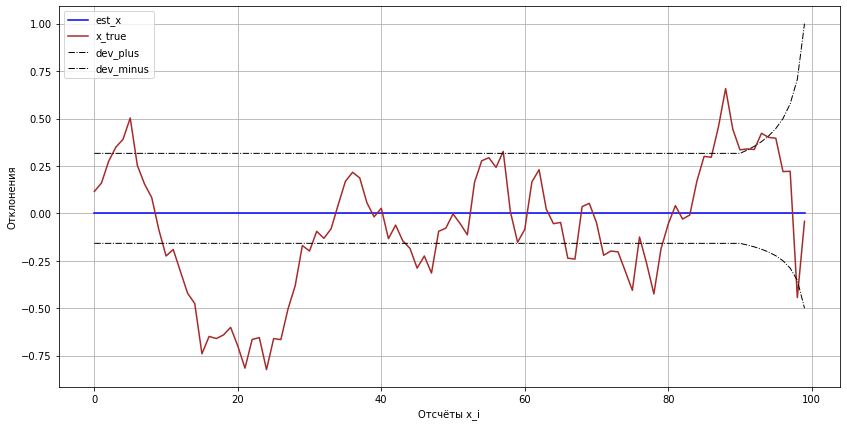

In [197]:
print('СЛУЧАЙ МАЛОГО N, K ~ 10')
est_x, true_x, d_est = estimate_ver_2(k = 10, N = 10)
cls_2 = generate_model()
cls_2.show_graphs(est_x = est_x, x_true = true_x, dev_plus = est_x + d_est, dev_minus = est_x - d_est / 2)

СЛУЧАЙ СРЕДНЕГО N, K ~ 100
число калибровочных данных k : 100
 число отсчётов n : 100
число данных N: 100


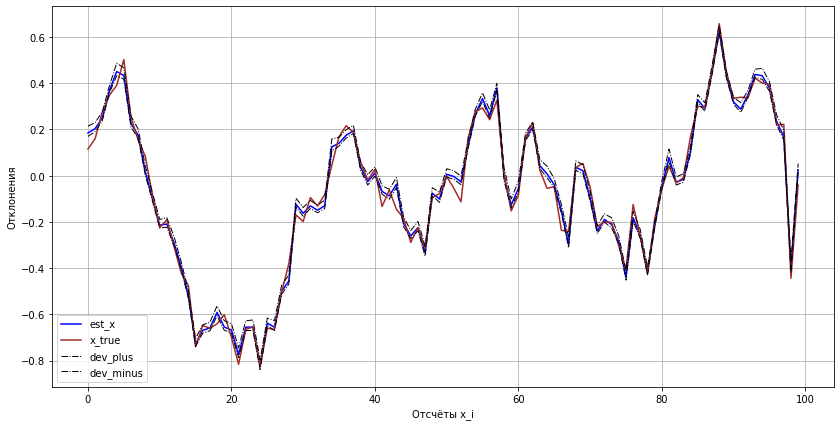

In [193]:
print('СЛУЧАЙ СРЕДНЕГО N, K ~ 100')
est_x, true_x, d_est = estimate_ver_2(k = 100, N = 100)
cls_2 = generate_model()
cls_2.show_graphs(est_x = est_x, x_true = true_x, dev_plus = est_x + d_est, dev_minus = est_x - d_est / 2)

СЛУЧАЙ БОЛЬШЕГО N, K ~ 1000
число калибровочных данных k : 1000
 число отсчётов n : 100
число данных N: 1000


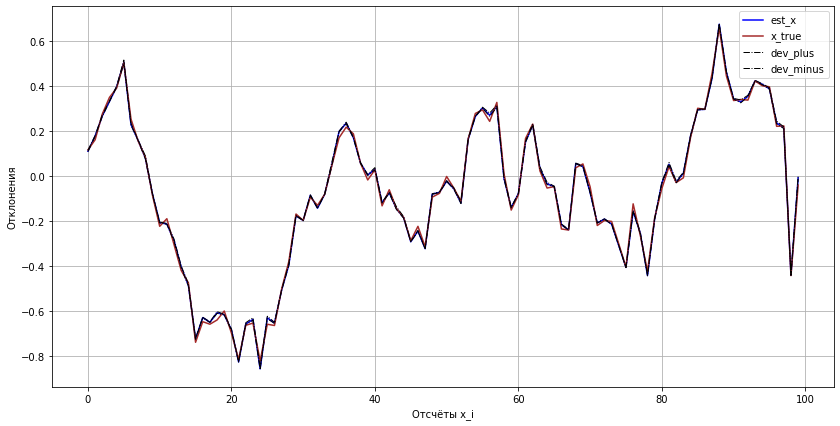

In [195]:
print('СЛУЧАЙ БОЛЬШЕГО N, K ~ 1000')
est_x, true_x, d_est = estimate_ver_2(k = 1000, N = 1000)
cls_2 = generate_model()
cls_2.show_graphs(est_x = est_x, x_true = true_x, dev_plus = est_x + d_est, dev_minus = est_x - d_est / 2)